In [227]:
import sqlite3
import pandas as pd

In [228]:
db_path = "/content/database.sqlite"
conn = sqlite3.connect(db_path)

In [229]:
# Match 테이블 불러오기
# 변수가 100개가 넘어서 모델링에 사용할 변수만 선택
query = """
SELECT
    match_api_id, date, season, stage,
    home_team_api_id, away_team_api_id,
    home_team_goal, away_team_goal,
    home_player_1, home_player_2, home_player_3, home_player_4, home_player_5,
    home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11,
    away_player_1, away_player_2, away_player_3, away_player_4, away_player_5,
    away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11
FROM Match
WHERE home_player_1 IS NOT NULL AND away_player_1 IS NOT NULL
"""
match_df = pd.read_sql(query, conn)

In [230]:
# 경기 결과를 Win, Defeat, Draw로 반환하는 함수 생성
def get_result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 'Win'
    elif row['home_team_goal'] < row['away_team_goal']:
        return 'Defeat'
    else:
        return 'Draw'

match_df['result'] = match_df.apply(get_result, axis=1)


In [231]:
player_attrs = pd.read_sql("""
    SELECT player_api_id, date, overall_rating, potential, stamina
    FROM Player_Attributes
    WHERE overall_rating IS NOT NULL
""", conn)

# 날짜 포맷 정리
player_attrs['date'] = pd.to_datetime(player_attrs['date'])
match_df['date'] = pd.to_datetime(match_df['date'])

# 선수별 최신 능력치만 가져오기
latest_attrs = (
    player_attrs.sort_values(['player_api_id', 'date'])
    .drop_duplicates(subset=['player_api_id'], keep='last')
    .set_index('player_api_id')
)[['overall_rating', 'potential', 'stamina']]

In [232]:
home_players = [f'home_player_{i}' for i in range(1, 12)]
away_players = [f'away_player_{i}' for i in range(1, 12)]

# 홈팀 선수 능력치
for col in home_players:
    match_df = match_df.merge(
        latest_attrs[['overall_rating']].rename(columns={'overall_rating': f'ovr_{col}'}),
        left_on=col,
        right_index=True,
        how='left'
    )

# 어웨이팀 선수 능력치
for col in away_players:
    match_df = match_df.merge(
        latest_attrs[['overall_rating']].rename(columns={'overall_rating': f'ovr_{col}'}),
        left_on=col,
        right_index=True,
        how='left'
    )

In [233]:
# 각 선수의 최신 능력치 불러온 후, 각 경기의 홈/어웨이 팀 선수 11명의 능력치를 병합 (평균)
match_df['home_avg_rating'] = match_df[[f'ovr_home_player_{i}' for i in range(1, 12)]].mean(axis=1)
match_df['away_avg_rating'] = match_df[[f'ovr_away_player_{i}' for i in range(1, 12)]].mean(axis=1)

In [234]:
team_attrs = pd.read_sql("""
    SELECT *
    FROM Team_Attributes
    WHERE buildUpPlaySpeed IS NOT NULL
""", conn)

# 날짜 처리
team_attrs['date'] = pd.to_datetime(team_attrs['date'])
match_df['date'] = pd.to_datetime(match_df['date'])

In [235]:
def get_latest_team_attr(team_id, match_date, team_attrs):
    """
    특정 팀의 경기일 이전 전략 정보 중 가장 최근 값을 반환
    """
    past_attrs = team_attrs[
        (team_attrs['team_api_id'] == team_id) &
        (team_attrs['date'] <= match_date)
    ]
    if not past_attrs.empty:
        return past_attrs.sort_values('date').iloc[-1]
    else:
        return pd.Series()

def get_team_attributes(match_df, team_attrs, team_col_prefix):
    """
    홈팀 또는 어웨이팀 전략을 match_df에 붙임
    """
    features = []

    for _, row in match_df.iterrows():
        team_id = row[f"{team_col_prefix}_team_api_id"]
        match_date = row['date']
        team_attr = get_latest_team_attr(team_id, match_date, team_attrs)
        features.append(team_attr)

    features_df = pd.DataFrame(features)
    features_df = features_df.add_prefix(f"{team_col_prefix}_")

    return pd.concat([match_df.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)


In [236]:
# 전략에서 사용할 변수만 선택
cols_to_use = [
    'team_api_id', 'date',
    'buildUpPlaySpeed', 'chanceCreationPassing', 'defencePressure'
]
team_attrs_sub = team_attrs[cols_to_use].copy()
team_attrs_sub['date'] = pd.to_datetime(team_attrs_sub['date'])

# 홈팀 전략 병합
match_with_home = get_team_attributes(match_df, team_attrs_sub, team_col_prefix='home')

# 어웨이팀 전략 병합
match_with_all = get_team_attributes(match_with_home, team_attrs_sub, team_col_prefix='away')

In [237]:
# 모델에 사용할 변수만 추린 후 데이터 프레임 생성
selected_columns = [
    'home_avg_rating', 'away_avg_rating',
    'home_buildUpPlaySpeed', 'away_buildUpPlaySpeed',
    'home_chanceCreationPassing', 'away_chanceCreationPassing',
    'home_defencePressure', 'away_defencePressure',
    'result'
]

final_df = match_with_all[selected_columns].copy()

In [238]:
# 결측치 확인
print(final_df.isnull().sum())

home_avg_rating                  0
away_avg_rating                  0
home_buildUpPlaySpeed         4977
away_buildUpPlaySpeed         4962
home_chanceCreationPassing    4977
away_chanceCreationPassing    4962
home_defencePressure          4977
away_defencePressure          4962
result                           0
dtype: int64


In [239]:
final_df = final_df.dropna()
print(final_df.isnull().sum())

home_avg_rating               0
away_avg_rating               0
home_buildUpPlaySpeed         0
away_buildUpPlaySpeed         0
home_chanceCreationPassing    0
away_chanceCreationPassing    0
home_defencePressure          0
away_defencePressure          0
result                        0
dtype: int64


In [240]:
# 라이브러리 불러오기
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Draw vs NotDraw (이진 분류용 데이터 준비)

# 타겟: 'Draw'이면 1, 아니면 0
binary_y = (final_df['result'] == 'Draw').astype(int)

# 피처에서 결과 변수 제거
X_binary = final_df.drop(columns=['result']).values

# 학습/테스트 셋 분할
X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(
    X_binary, binary_y, test_size=0.2, stratify=binary_y, random_state=42
)

In [241]:
# colab에서 catboost 모듈 설치
!pip install catboost

In [242]:
# CatBoost 이진 분류기 학습 (Draw 여부 판단)
from catboost import CatBoostClassifier

draw_clf = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='F1',
    verbose=100,
    random_seed=42
)

draw_clf.fit(X_binary_train, y_binary_train)

0:	learn: 0.0041623	total: 6.74ms	remaining: 2.02s
100:	learn: 0.0078003	total: 1.1s	remaining: 2.16s
200:	learn: 0.0650694	total: 2.98s	remaining: 1.47s
299:	learn: 0.1246639	total: 4.94s	remaining: 0us


In [243]:
# 다중 분류용 데이터 준비

# 클래스 인코딩 (Win, Draw, Defeat → 숫자)
le = LabelEncoder()
y_multi = le.fit_transform(final_df['result'])

# 학습/테스트 셋 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y_multi, test_size=0.2, stratify=y_multi, random_state=42
)

# CatBoost 다중 분류기 학습 (전체 경기 결과 예측)
cat_model = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    verbose=100,
    random_seed=42
)

cat_model.fit(X_train, y_train)

0:	learn: 0.4078504	total: 30.9ms	remaining: 9.23s
100:	learn: 0.4655914	total: 1.22s	remaining: 2.41s
200:	learn: 0.5022910	total: 3.19s	remaining: 1.57s
299:	learn: 0.5326190	total: 6.79s	remaining: 0us


Classification Report (Combined):
              precision    recall  f1-score   support

      Defeat       0.61      0.40      0.48      1097
        Draw       0.46      0.66      0.54       957
         Win       0.65      0.64      0.65      1723

    accuracy                           0.58      3777
   macro avg       0.58      0.57      0.56      3777
weighted avg       0.59      0.58      0.57      3777



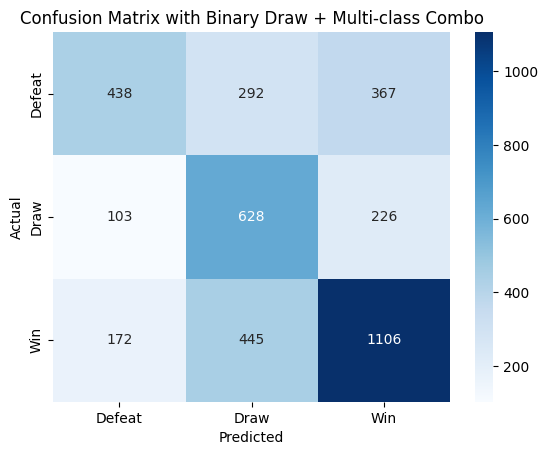

In [244]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Draw 이진 분류기 확률 예측
draw_probs = draw_clf.predict_proba(X_test)[:, 1]

# 다중 클래스 예측 결과
multi_probs = cat_model.predict_proba(X_test)
y_pred_multi = np.argmax(multi_probs, axis=1)

# 조합: Draw 확률이 일정 기준이상이면 무조건 Draw로 수정
# 코드의 0.28 부분 수치를 조정하면서 하이퍼파라미터 튜닝 진행하였습니다!
y_combined = y_pred_multi.copy()
y_combined[draw_probs > 0.28] = 1  # 1 = Draw

# 평가 및 시각화
print("Classification Report (Combined):")
print(classification_report(y_test, y_combined, target_names=le.classes_))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_combined)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Binary Draw + Multi-class Combo')
plt.show()